In [1]:
%matplotlib widget

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Arturo Mena López

Script to simulate the passage of a Gaussian packet wave function through a double slit of finite potential barrier walls of height V0.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle


In [3]:
def psi0(x, y, x0, y0, sigma=0.5, k=15*np.pi):
    
    """
    Proposed wave function for the initial time t=0.
    Initial position: (x0, y0)
    Default parameters:
        - sigma = 0.5 -> Gaussian dispersion.
        - k = 15*np.pi -> Proportional to the momentum.
        
    Note: if Dy=0.1 use np.exp(-1j*k*(x-x0)), if Dy=0.05 use 
          np.exp(1j*k*(x-x0)) so that the particle will move 
          to the right.
    """
    
    return np.exp(-1/2*((x-x0)**2 + (y-y0)**2)/sigma**2)*np.exp(1j*k*(x-x0))


In [4]:
# =============================================================================
# Parameters
# =============================================================================

L = 8 # Well of width L. Shafts from 0 to +L.
Dy = .05 # Spatial step size.
Dt = Dy**2/4 # Temporal step size.
Nx = int(L/Dy) + 1 # Number of points on the x axis.
Ny = int(L/Dy) + 1 # Number of points on the y axis.
Nt = 500 # Number of time steps.
rx = -Dt/(2j*Dy**2) # Constant to simplify expressions.
ry = -Dt/(2j*Dy**2) # Constant to simplify expressions.

# Initial position of the center of the Gaussian wave function.
x0 = L/5
y0 = L/2

# Parameters of the double slit.
w = 0.6 # Width of the walls of the double slit.
s = 0.8 # Separation between the edges of the slits.
a = 0.2 # Aperture of the slits.

# Indices that parameterize the double slit in the space of points.
# Horizontal axis.
j0 = int(1/(2*Dy)*(L-w)) # Left edge.
j1 = int(1/(2*Dy)*(L+w)) # Right edge.
# Eje vertical.
i0 = int(1/(2*Dy)*(L+s) + a/Dy) # Lower edge of the lower slit.
i1 = int(1/(2*Dy)*(L+s))        # Upper edge of the lower slit.
i2 = int(1/(2*Dy)*(L-s))        # Lower edge of the upper slit.
i3 = int(1/(2*Dy)*(L-s) - a/Dy) # Upper edge of the upper slit.

# We generate the potential related to the double slit.
v0 = 200
v = np.zeros((Ny,Ny), complex) 
#v[0:i3, j0:j1] = v0
#v[i2:i1,j0:j1] = v0
#v[i0:,  j0:j1] = v0
v[:, j0:j1] = v0
    
Ni = (Nx-2)*(Ny-2)  # Number of unknown factors v[i,j], i = 1,...,Nx-2, j = 1,...,Ny-2
print(Ny, Ni)

161 25281


In [5]:
# =============================================================================
# First step: Construct the matrices of the system of equations.
# =============================================================================

# Matrices for the Crank-Nicolson calculus. The problem A·x[n+1] = b = M·x[n] will be solved at each time step.
A = np.zeros((Ni,Ni), complex)
M = np.zeros((Ni,Ni), complex)

# We fill the A and M matrices.
for k in range(Ni):     
    
    # k = (i-1)*(Ny-2) + (j-1)
    i = 1 + k//(Ny-2)
    j = 1 + k%(Ny-2)
    
    # Main central diagonal.
    A[k,k] = 1 + 2*rx + 2*ry + 1j*Dt/2*v[i,j]
    M[k,k] = 1 - 2*rx - 2*ry - 1j*Dt/2*v[i,j]
    
    if i != 1: # Lower lone diagonal.
        A[k,(i-2)*(Ny-2)+j-1] = -ry 
        M[k,(i-2)*(Ny-2)+j-1] = ry
        
    if i != Nx-2: # Upper lone diagonal.
        A[k,i*(Ny-2)+j-1] = -ry
        M[k,i*(Ny-2)+j-1] = ry
    
    if j != 1: # Lower main diagonal.
        A[k,k-1] = -rx 
        M[k,k-1] = rx 

    if j != Ny-2: # Upper main diagonal.
        A[k,k+1] = -rx
        M[k,k+1] = rx



In [6]:
# =============================================================================
# Second step: Solve the A·x[n+1] = M·x[n] system for each time step.
# =============================================================================

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

Asp = csc_matrix(A)

x = np.linspace(0, L, Ny-2) # Array of spatial points.
y = np.linspace(0, L, Ny-2) # Array of spatial points.
x, y = np.meshgrid(x, y)
psis = [] # To store the wave function at each time step.

psi = psi0(x, y, x0, y0) # We initialise the wave function with the Gaussian.
psi[0,:] = psi[-1,:] = psi[:,0] = psi[:,-1] = 0 # The wave function equals 0 at the edges of the simulation box (infinite potential well).
psis.append(np.copy(psi)) # We store the wave function of this time step.

# We solve the matrix system at each time step in order to obtain the wave function.
for i in range(1,Nt):
    psi_vect = psi.reshape((Ni)) # We adjust the shape of the array to generate the matrix b of independent terms.
    b = np.matmul(M,psi_vect) # We calculate the array of independent terms.
    psi_vect = spsolve(Asp,b) # Resolvemos el sistema para este paso temporal.
    psi = psi_vect.reshape((Nx-2,Ny-2)) # Recuperamos la forma del array de la función de onda.
    psis.append(np.copy(psi)) # Save the result.

# We calculate the modulus of the wave function at each time step.
mod_psis = [] # For storing the modulus of the wave function at each time step.
for wavefunc in psis:
    re = np.real(wavefunc) # Real part.
    im = np.imag(wavefunc) # Imaginary part.
    mod = np.sqrt(re**2 + im**2) # We calculate the modulus.
    mod_psis.append(mod) # We save the calculated modulus.


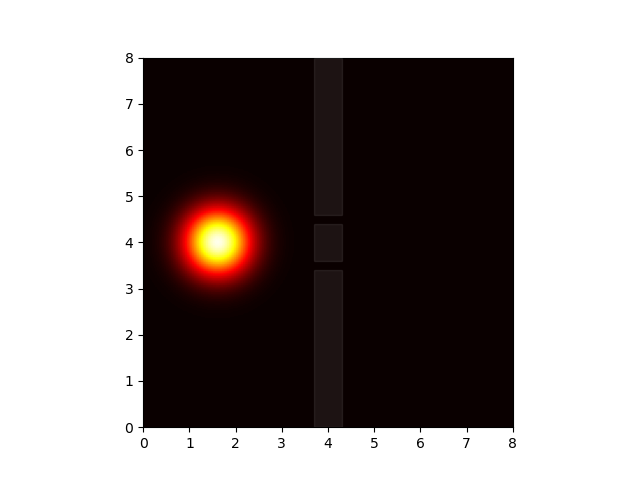

'\nloaded_mod_psis = np.loadtxt("mod_psis_data.txt")\n  \n# The loaded_mod_psis array is a 2D array, we need to return it to its original form.\n\nmod_psisshape2 = Ny-2\n\n# We finally obtain our mod_psis array.\n\nmod_psis = loaded_mod_psis.reshape( \n    loaded_mod_psis.shape[0], loaded_mod_psis.shape[1] // mod_psisshape2, mod_psisshape2) \n  \n## For deleting the auxiliary 2D array.\n# del loaded_mod_psis\n'

In [7]:
## In case there is a need to save memory.
# del psis
# del M
# del psi_vect
# del A
# del Asp
# del b
# del im 
# del re
# del psi

#%%
# =============================================================================
# Third step: We make the animation.
# =============================================================================

fig = plt.figure() # We create the figure.
ax = fig.add_subplot(111, xlim=(0,L), ylim=(0,L)) # We add the subplot to the figure.

img = ax.imshow(mod_psis[0], extent=[0,L,0,L], cmap=plt.get_cmap("hot"), vmin=0, vmax=np.max(mod_psis), zorder=1) # Here the modulus of the 2D wave function shall be represented.

# We paint the walls of the double slit with rectangles.
slitcolor = "w" # Color of the rectangles.
slitalpha = 0.08 # Transparency of the rectangles.
wall_bottom = Rectangle((j0*Dy,0),     w, i3*Dy,      color=slitcolor, zorder=50, alpha=slitalpha) # (x0, y0), width, height
wall_middle = Rectangle((j0*Dy,i2*Dy), w, (i1-i2)*Dy, color=slitcolor, zorder=50, alpha=slitalpha)
wall_top    = Rectangle((j0*Dy,i0*Dy), w, i3*Dy,      color=slitcolor, zorder=50, alpha=slitalpha)

# We add the rectangular patches to the plot.
ax.add_patch(wall_bottom)
ax.add_patch(wall_middle)
ax.add_patch(wall_top)

# We define the animation function for FuncAnimation.

def animate(i):
    
    """
    Animation function. Paints each frame. Function for Matplotlib's 
    FuncAnimation.
    """
    
    img.set_data(mod_psis[i]) # Fill img with the modulus data of the wave function.
    img.set_zorder(1)
    
    return img, # We return the result ready to use with blit=True.


anim = FuncAnimation(fig, animate, interval=20, frames =np.arange(0,Nt,2), repeat=True, blit=0) # We generate the animation.# Generamos la animación.
plt.show() # We finally show the animation.

## Save the animation (Ubuntu).
# anim.save('./animationsName.mp4', writer="ffmpeg", fps=60)

#%%
### For saving the data.
"""
# We transform the 3D array into a 2D array to save it with numpy.savetxt.
mod_psis_reshaped = np.asarray(mod_psis).reshape(np.asarray(mod_psis).shape[0], -1) 
  
# We save the 2D array as a text file.
np.savetxt("mod_psis_data.txt", mod_psis_reshaped)
"""

#%%
### To obtain the data from the text file already created earlier.
"""
loaded_mod_psis = np.loadtxt("mod_psis_data.txt")
  
# The loaded_mod_psis array is a 2D array, we need to return it to its original form.

mod_psisshape2 = Ny-2

# We finally obtain our mod_psis array.

mod_psis = loaded_mod_psis.reshape( 
    loaded_mod_psis.shape[0], loaded_mod_psis.shape[1] // mod_psisshape2, mod_psisshape2) 
  
## For deleting the auxiliary 2D array.
# del loaded_mod_psis
"""

In [8]:
print(v[:, j0:j1])

[[200.+0.j 200.+0.j 200.+0.j ... 200.+0.j 200.+0.j 200.+0.j]
 [200.+0.j 200.+0.j 200.+0.j ... 200.+0.j 200.+0.j 200.+0.j]
 [200.+0.j 200.+0.j 200.+0.j ... 200.+0.j 200.+0.j 200.+0.j]
 ...
 [200.+0.j 200.+0.j 200.+0.j ... 200.+0.j 200.+0.j 200.+0.j]
 [200.+0.j 200.+0.j 200.+0.j ... 200.+0.j 200.+0.j 200.+0.j]
 [200.+0.j 200.+0.j 200.+0.j ... 200.+0.j 200.+0.j 200.+0.j]]


In [9]:
j0

74

In [10]:
j1

86

In [11]:
A

array([[ 1.+0.5j  , -0.-0.125j,  0.+0.j   , ...,  0.+0.j   ,  0.+0.j   ,
         0.+0.j   ],
       [-0.-0.125j,  1.+0.5j  , -0.-0.125j, ...,  0.+0.j   ,  0.+0.j   ,
         0.+0.j   ],
       [ 0.+0.j   , -0.-0.125j,  1.+0.5j  , ...,  0.+0.j   ,  0.+0.j   ,
         0.+0.j   ],
       ...,
       [ 0.+0.j   ,  0.+0.j   ,  0.+0.j   , ...,  1.+0.5j  , -0.-0.125j,
         0.+0.j   ],
       [ 0.+0.j   ,  0.+0.j   ,  0.+0.j   , ..., -0.-0.125j,  1.+0.5j  ,
        -0.-0.125j],
       [ 0.+0.j   ,  0.+0.j   ,  0.+0.j   , ...,  0.+0.j   , -0.-0.125j,
         1.+0.5j  ]])